In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from utilities import train_test_val_split, load_matlab_data, rmse
from sklearn.metrics import make_scorer

In [2]:
x, y = load_matlab_data("data/hwkdataNEW.mat")
xtr, ytr, xts, yts, xv, yv = train_test_val_split(x, y, seed=3)
ytr = ytr.reshape((-1, 1))
yts = yts.reshape((-1, 1))
yv = yv.reshape((-1, 1))

In [3]:
xscaler = StandardScaler().fit(xtr)
yscaler = StandardScaler().fit(ytr)

In [4]:
xs = xscaler.transform(xtr)
ys = yscaler.transform(ytr)

# Linear baseline

In [5]:
lin = LinearRegression(fit_intercept=False).fit(xs, ys)

In [6]:
x_test_scaled = xscaler.transform(xts)
y_test_scaled = yscaler.transform(yts)

In [7]:
lin_error = rmse(yts, lin.predict(x_test_scaled))
print(f"Error for linear regression: {lin_error}")

Error for linear regression: 19.353197665296634


# $\alpha$ determination

## Leave-one-out cross validation method

In [8]:
alpha_parameters = np.logspace(-2, 3)
params = {'alpha': alpha_parameters}
ridge_loo = GridSearchCV(Ridge(fit_intercept=False), 
                         param_grid=params, cv=LeaveOneOut(), 
                         scoring=make_scorer(rmse, greater_is_better=False))
ridge_loo.fit(xs, ys)

GridSearchCV(cv=LeaveOneOut(), error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.00000e-02, 1.26486e-02, 1.59986e-02, 2.02359e-02, 2.55955e-02,
       3.23746e-02, 4.09492e-02, 5.17947e-02, 6.55129e-02, 8.28643e-02,
       1.04811e-01, 1.32571e-01, 1.67683e-01, 2.12095e-01, 2.68270e-01,
       3.39322e-01, 4.29193e-01, 5.42868e-01, 6.86649e-01, 8.68... 2.44205e+02, 3.08884e+02,
       3.90694e+02, 4.94171e+02, 6.25055e+02, 7.90604e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

In [9]:
ridge_loo.best_params_

{'alpha': 0.10481131341546858}

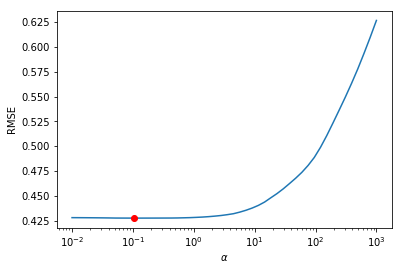

In [10]:
plt.plot(ridge_loo.cv_results_['param_alpha'], -ridge_loo.cv_results_['mean_test_score'])
plt.plot(ridge_loo.best_params_['alpha'], -ridge_loo.best_score_, 'ro')
plt.xlabel(r"$\alpha$")
plt.ylabel("RMSE")
plt.xscale("log")
plt.show()

## L-curve method

In [11]:
models = [Ridge(alpha=a, fit_intercept=False).fit(xs, ys) for a in alpha_parameters]

In [12]:
norm_b = [la.norm(m.coef_) for m in models]
rmse_vs_alpha = [rmse(yts, yscaler.inverse_transform(m.predict(x_test_scaled))) for m in models]

In [13]:
rmse_vs_alpha = [rmse(ytr, yscaler.inverse_transform(m.predict(xs))) for m in models]

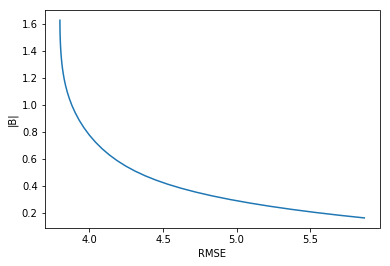

In [14]:
plt.plot(rmse_vs_alpha, norm_b)
plt.xlabel("RMSE")
plt.ylabel("|B|")
plt.show()

### Find the point closest to the origin

In [15]:
paired_points = np.array([_ for _ in zip(rmse_vs_alpha, norm_b)])

In [16]:
min_norm_ind = np.where(la.norm(paired_points, axis=1) == np.min(la.norm(paired_points, axis=1)))[0][0]
print(f"Minimum distance from origin is at index {min_norm_ind}")

Minimum distance from origin is at index 24


In [17]:
a = alpha_parameters[min_norm_ind]
print(f"The best alpha is {a}")

The best alpha is 2.8117686979742307


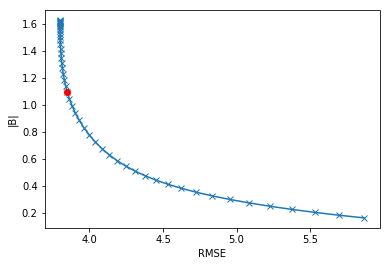

In [18]:
plt.plot(rmse_vs_alpha, norm_b, "x-")
plt.plot(rmse_vs_alpha[min_norm_ind], norm_b[min_norm_ind], 'ro')
plt.xlabel("RMSE")
plt.ylabel("|B|")
plt.show()

In [19]:
ridge_lc = Ridge(alpha=a, fit_intercept=False).fit(xs, ys)

## Compare the two

In [20]:
error_loo = rmse(yts, yscaler.inverse_transform(ridge_loo.predict(x_test_scaled)))
error_lc = rmse(yts, yscaler.inverse_transform(ridge_lc.predict(x_test_scaled)))
print(f"Leave one out CV\talpha: {ridge_loo.best_params_['alpha']:0.2f}\t\tRMSE: {error_loo:0.2f}")
print(f"L-curve method\t\talpha: {ridge_lc.alpha:0.2f}\t\tRMSE: {error_lc:0.2f}")
print(f"Linear regression\t\t\t\tRMSE: {lin_error:0.2f}")

Leave one out CV	alpha: 0.10		RMSE: 3.83
L-curve method		alpha: 2.81		RMSE: 3.86
Linear regression				RMSE: 19.35


# Condition number

In [21]:
# Training matrix condition number
print(f"Condition no. of training matrix: {la.cond(xtr):0.2f}")

Condition no. of training matrix: 605.56


In [22]:
# Scaled training matrix condition number
print(f"Condition no. of scaled training matrix: {la.cond(xs):0.2f}")

Condition no. of scaled training matrix: 45.35


In [23]:
def cond_ridge(x, alpha):
    u, s, v = la.svd(x)
    c_n = np.max(s) + alpha ** 2
    c_d = np.min(s) + alpha ** 2
    c = c_n / c_d
    return c

In [24]:
print(f"Condition no. for ridge regression: {cond_ridge(xs, ridge_lc.alpha):0.2f}")

Condition no. for ridge regression: 5.58
